# Imports

In [1]:
import numpy as np
import pandas as pd
import os
import csv
import cv2
import random
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from sklearn.model_selection import train_test_split
import keras as kr
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.layers import Lambda, Conv2D, MaxPooling2D, Dropout, Dense, Flatten, Reshape, Input, Bidirectional, TimeDistributed, GRU, LSTM, BatchNormalization, ConvLSTM2D, Concatenate
from subprocess import call
import glob
import Automold as am
import Helpers as hp

# Data Extraction 

Skip these cells if the data is already extracted.

In [7]:
## Don't need to run this if frames have been extracted
video_file = 'train'

video_id = './data_comma/' + video_file + '.mp4'
label_id = './data_comma/' + video_file + '.txt'

try:
    if not os.path.exists('./data_comma/data_frames'):
        os.makedirs('./data_comma/data_frames')
except OSError:
    print('Where is the data directory?')

video_reader = cv2.VideoCapture(video_id)
train_label = open('./data_comma/labels.txt', 'w')
label_file = open(label_id, 'r')
label_arr = label_file.read().split()

counter = 0

while(True):
    ret, frame = video_reader.read()

    if ret:
        name = './data_comma/data_frames/Frame' + str(counter) + '.jpg'
        cv2.imwrite(name, frame)
        train_label.write(str(label_arr[counter]) + '\n')
        counter += 1
    else:
        break
        
video_reader.release()
train_label.close()

In [8]:
# Don't need to run this if the data of optical flow is ready
try:
    if not os.path.exists('./data_comma/optical_flow_frames'):
        os.makedirs('./data_comma/optical_flow_frames')
except OSError:
    print('Where is the data directory?')
counter = 0
# Get a VideoCapture object from video and store it in vs
vc = cv2.VideoCapture('./data_comma/train.mp4')
# Read first frame
ret, first_frame = vc.read()
# Scale and resize image
resize_dim = 600
max_dim = max(first_frame.shape)
scale = resize_dim/max_dim
first_frame = cv2.resize(first_frame, None, fx=scale, fy=scale)
# Convert to gray scale 
prev_gray = cv2.cvtColor(first_frame, cv2.COLOR_BGR2GRAY)


# Create mask
mask = np.zeros_like(first_frame)
# Sets image saturation to maximum
mask[..., 1] = 255


out = cv2.VideoWriter('Optical.mp4',-1,1,(600, 600))

while(1):
    # Read a frame from video
    ret, frame = vc.read()
    if ret is False:
        break
    
    # Convert new frame format`s to gray scale and resize gray frame obtained
    gray = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
    gray = cv2.resize(gray, None, fx=scale, fy=scale)

    # Calculate dense optical flow by Farneback method
    # https://docs.opencv.org/3.0-beta/modules/video/doc/motion_analysis_and_object_tracking.html#calcopticalflowfarneback
    flow = cv2.calcOpticalFlowFarneback(prev_gray, gray, None, pyr_scale = 0.5, levels = 3, winsize = 15, iterations = 5, poly_n = 5, poly_sigma = 1.2, flags = 0)
    #flow = cv2.calcOpticalFlowFarneback(prev_gray, gray, None, pyr_scale = 0.5, levels = 5, winsize = 11, iterations = 5, poly_n = 5, poly_sigma = 1.1, flags = 0)
    # Compute the magnitude and angle of the 2D vectors
    magnitude, angle = cv2.cartToPolar(flow[..., 0], flow[..., 1])
    # Set image hue according to the optical flow direction
    mask[..., 0] = angle * 180 / np.pi / 2
    # Set image value according to the optical flow magnitude (normalized)
    mask[..., 2] = cv2.normalize(magnitude, None, 0, 255, cv2.NORM_MINMAX)
    # Convert HSV to RGB (BGR) color representation
    rgb = cv2.cvtColor(mask, cv2.COLOR_HSV2BGR)
    
    # Resize frame size to match dimensions
    frame = cv2.resize(frame, None, fx=scale, fy=scale)
    
    # Open a new window and displays the output frame
    dense_flow = cv2.addWeighted(frame, 1,rgb, 2, 0)
#     cv2.imshow("Dense optical flow", dense_flow)
    out.write(dense_flow)
    # Update previous frame
    prev_gray = gray
    # Frame are read by intervals of 1 millisecond. The programs breaks out of the while loop when the user presses the 'q' key
    if cv2.waitKey(10) & 0xFF == ord('q'):
        break
    else:
        name = './data_comma/optical_flow_frames/Frame' + str(counter) + '.jpg'
        cv2.imwrite(name, dense_flow)
        #train_label.write(label_id[counter])
        counter += 1
# The following frees up resources and closes all windows
vc.release()

cv2.destroyAllWindows()

# Data preparation

In [2]:
# Data preparation for optical flow

op_frame_dir = './data_comma/optical_flow_frames'
label_dir = './data_comma/train.txt'
labels_file = './data_comma/OpticalData.csv'

def create_csv(csv_file, label_file):
    label_file = open(label_file, 'r')
    label_arr = label_file.read().split()
    df = pd.DataFrame([['Frame' + str(i) + '.jpg', label_arr[i]] for i in range(len(label_arr))]
                      , columns = ('VideoFrames', 'Speeds'))
    df.to_csv(csv_file)


def load_data(labels_file, test_size):
    """
    Display a list of images in a single figure with matplotlib.
        Parameters:
            labels_file: The labels CSV file.
            test_size: The size of the testing set.
    """
    labels = pd.read_csv(labels_file)
    X = labels['VideoFrames'].values
    y = labels['Speeds'].values
    #X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size, random_state=0)
    X_train, X_test, y_train, y_test = X[:int(len(X)*(1-test_size/2))], X[int(len(X)*(1-test_size)):], y[:int(len(X)*(1-test_size/2))], y[int(len(X)*(1-test_size)):]

    return X_train, X_test, y_train, y_test

def load_image(data_dir, image_file):
    """
    Load RGB image.
        Parameters:
            data_dir: The directory where the images are.
            image_file: The image file name.
    """
    return mpimg.imread(os.path.join(data_dir, image_file.strip()))


create_csv(labels_file, label_dir)
data = load_data(labels_file, 0.1)
print(data)

(array(['Frame0.jpg', 'Frame1.jpg', 'Frame2.jpg', ..., 'Frame19377.jpg',
       'Frame19378.jpg', 'Frame19379.jpg'], dtype=object), array(['Frame18360.jpg', 'Frame18361.jpg', 'Frame18362.jpg', ...,
       'Frame20397.jpg', 'Frame20398.jpg', 'Frame20399.jpg'], dtype=object), array([28.105569, 28.105569, 28.106527, ...,  2.866707,  2.874273,
        2.873002]), array([11.610579, 11.631442, 11.650229, ...,  2.292917,  2.2606  ,
        2.206759]))


In [3]:
# Data preparation for normal data


frame_dir = './data_comma/data_frames'
label_dir = './data_comma/train.txt'
labels_file = './data_comma/Data.csv'    

def load_data(labels_file, test_size):
    """
    Display a list of images in a single figure with matplotlib.
        Parameters:
            labels_file: The labels CSV file.
            test_size: The size of the testing set.
    """
    labels = pd.read_csv(labels_file)
    X = labels['VideoFrames'].values
    y = labels['Speeds'].values
    #X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size, random_state=0)
    X_train, X_test, y_train, y_test = X[:int(len(X)*(1-test_size/2))], X[int(len(X)*(1-test_size)):], y[:int(len(X)*(1-test_size/2))], y[int(len(X)*(1-test_size)):]

    return X_train, X_test, y_train, y_test

def load_image(data_dir, image_file):
    """
    Load RGB image.
        Parameters:
            data_dir: The directory where the images are.
            image_file: The image file name.
    """
    return mpimg.imread(os.path.join(data_dir, image_file.strip()))

create_csv(labels_file, label_dir)
data = load_data(labels_file, 0.1)
print(data)

(array(['Frame0.jpg', 'Frame1.jpg', 'Frame2.jpg', ..., 'Frame19377.jpg',
       'Frame19378.jpg', 'Frame19379.jpg'], dtype=object), array(['Frame18360.jpg', 'Frame18361.jpg', 'Frame18362.jpg', ...,
       'Frame20397.jpg', 'Frame20398.jpg', 'Frame20399.jpg'], dtype=object), array([28.105569, 28.105569, 28.106527, ...,  2.866707,  2.874273,
        2.873002]), array([11.610579, 11.631442, 11.650229, ...,  2.292917,  2.2606  ,
        2.206759]))


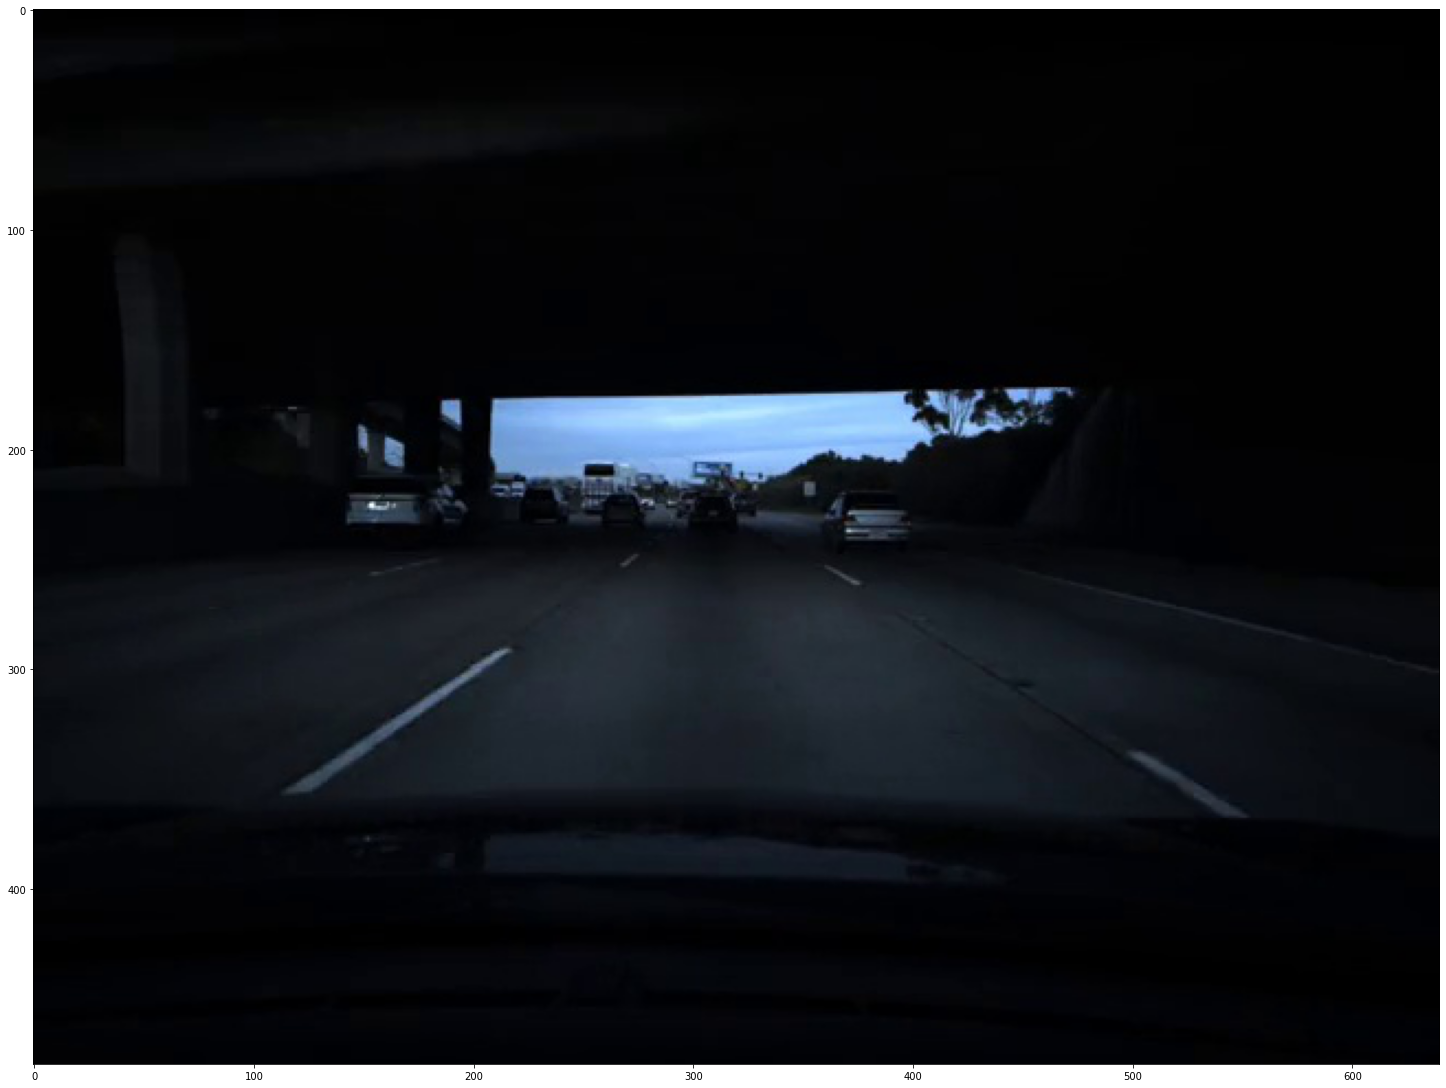

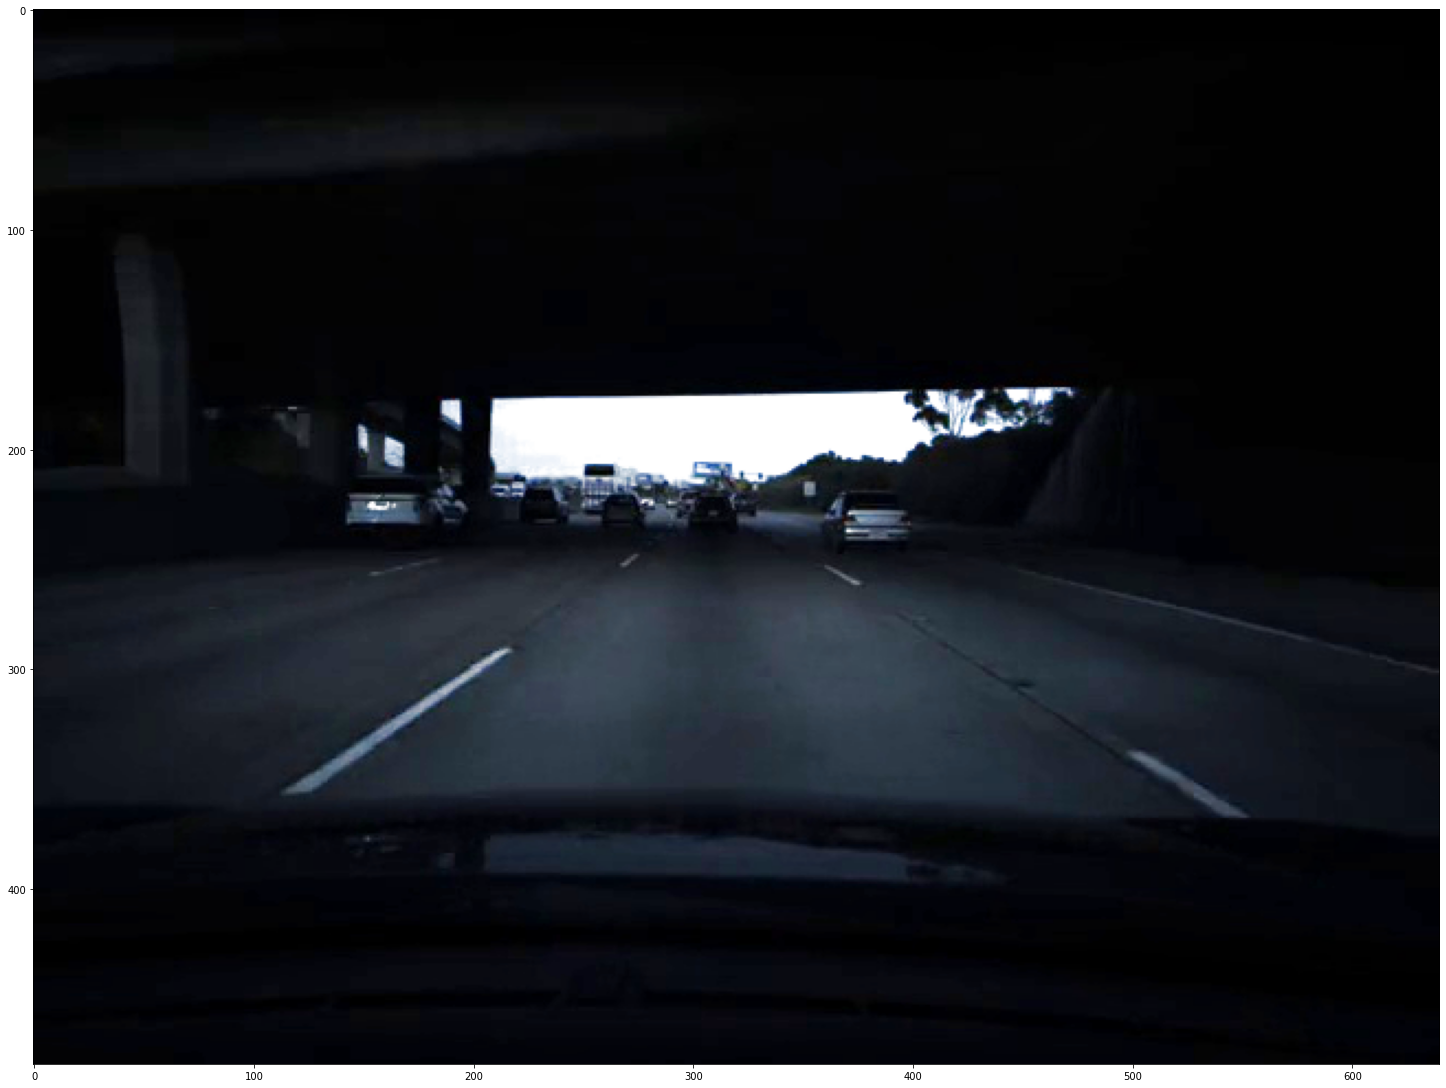

In [4]:
# Take a look at the data
image = load_image(frame_dir, data[0][16])
b_image= am.brighten(image, 0.5)
hp.visualize(image)
hp.visualize(b_image)

In [5]:
# Preprocessing of video frames

def random_flip(data_dir, image_file, speed):
    """
    Randomly flipping the input image horizontaly, with steering angle adjustment.
        Parameters:
            image: The input image.
            steering_angle: The steering angle related to the input image.
    """
    image = load_image(data_dir, image_file)
    if np.random.rand() < 0.5:
        image = cv2.flip(image, 1)
        speed = speed
    return image, speed

def random_shift(image, speed, range_x, range_y):
    """
    Shifting (Translating) the input images, with steering angle adjustment.
        Parameters:
            image: The input image.
            steering_angle: The steering angle related to the input image.
            range_x: Horizontal translation range.
            range_y: Vertival translation range.
    """
    trans_x = range_x * (np.random.rand() - 0.3)
    trans_y = range_y * (np.random.rand() - 0.3)
    speed += trans_x * 0.002
    trans_m = np.float32([[1, 0, trans_x], [0, 1, trans_y]])
    height, width = image.shape[:2]
    image = cv2.warpAffine(image, trans_m, (width, height))
    return image, speed

def random_shadow(image):
    """
    Adding shadow to the input image.
        Parameters:
            image: The input image.
    """
    bright_factor = 0.75
    x = random.randint(0, image.shape[1])
    y = random.randint(0, image.shape[0])
    width = random.randint(image.shape[1], image.shape[1])
    if(x + width > image.shape[1]):
        x = image.shape[1] - x
    height = random.randint(image.shape[0], image.shape[0])
    if(y + height > image.shape[0]):
        y = image.shape[0] - y
    image = cv2.cvtColor(image, cv2.COLOR_RGB2HSV)
    image[y:y+height,x:x+width,2] = image[y:y+height,x:x+width,2]*bright_factor
    return cv2.cvtColor(image, cv2.COLOR_HSV2RGB)

def random_brightness(image):
    """
    Altering the brightness of the input image.
        Parameters:
            image: The input image.
    """
    # HSV (Hue, Saturation, Value) is also called HSB ('B' for Brightness).
    image= am.brighten(image, 0.56)
    hsv = cv2.cvtColor(image, cv2.COLOR_RGB2HSV)
    #ratio = 1.3 + (np.random.rand() - 0.05)
    ratio = 1.25
    hsv[:,:,2] =  hsv[:,:,2] * ratio
    return cv2.cvtColor(hsv, cv2.COLOR_HSV2RGB)

def augument(data_dir, image_file, speed, range_x=100, range_y=10):
    """
    Generate an augumented image and adjust the associated steering angle.
        Parameters:
            data_dir: The directory where the images are.
            center: Center image.
            left: Left image.
            right: Right image
            steering_angle: The steering angle related to the input frame.
            range_x (Default = 100): Horizontal translation range.
            range_y (Default = 10): Vertival translation range.
    """
    image, speed = random_flip(data_dir, image_file, speed)
    image, speed = random_shift(image, speed, range_x, range_y)
    image = random_shadow(image)
    image = random_brightness(image)
    return image, speed

def preprocess(img):
    """
    Preprocessing (Crop - Resize - Convert to YUV) the input image.
        Parameters:
            img: The input image to be preprocessed.
    """
    # Cropping the image
    img = img[100:360, :-90, :]
    # Resizing the image
    img = cv2.resize(img, (IMAGE_WIDTH, IMAGE_HEIGHT), cv2.INTER_AREA)
    # Converting the image to YUV
    img = cv2.cvtColor(img, cv2.COLOR_RGB2YUV)
    #img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    #img =cv2.cvtColor(img, cv2.COLOR_RGB2BGR)
    return img

batch_size, time_step = 20, 4
IMAGE_HEIGHT, IMAGE_WIDTH, IMAGE_CHANNELS = 100, 220, 3
INPUT_SHAPE = (IMAGE_HEIGHT, IMAGE_WIDTH, IMAGE_CHANNELS)
INPUT_SHAPE1 = (time_step, IMAGE_HEIGHT, IMAGE_WIDTH, IMAGE_CHANNELS)
INPUT_SHAPE2 = (time_step,)
INPUT_SHAPE3 = (time_step, IMAGE_HEIGHT * IMAGE_WIDTH * IMAGE_CHANNELS)

# Dataset Speed Profile

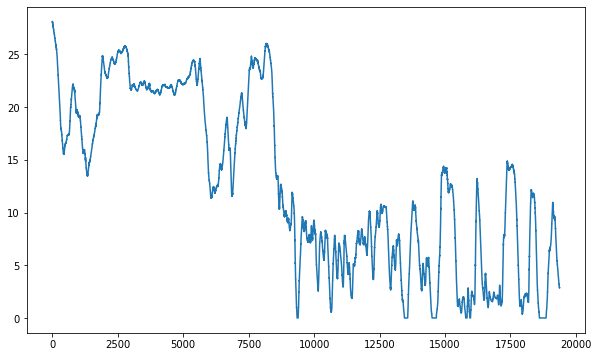

In [6]:
# Speed profile
plt.figure(figsize=(10,6))
plt.plot(data[2])
plt.show()

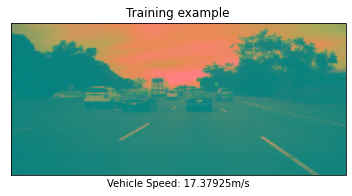

In [7]:
image = load_image(frame_dir, str(data[0][1116]))
def display(image, angle, label):
    plt.imshow(image)
    plt.xlabel("Vehicle Speed: {:.5f}".format(angle)+"m/s")
    plt.title(label)
    plt.xticks([])
    plt.yticks([])
    plt.show()

veh_speed = data[2][1116]
display(preprocess(image), veh_speed, "Training example")

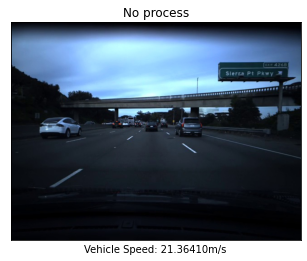

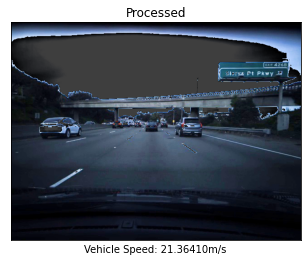

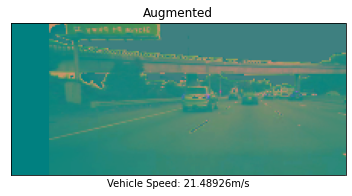

In [8]:
image = load_image(frame_dir, str(data[0][856]))
speed = data[2][856]
label = "No process"
display(image, speed, label)

image1 = random_brightness(image)
label = "Processed"
display(image1, speed, label)

image2, veh_speed = augument(frame_dir, str(data[0][856]), data[2][856])
image2 = preprocess(image2)
label = "Augmented"
display(image2, veh_speed, label)

# Project Models

## N2N_model1
This model consists of an LSTM structure taking in 4 input images. Those images are passed through 3 convolutional layers and then passed to a fully connected layer. This fully connected layer also makes use of a second input of the previous car speeds in the previous frames. This allows the network to use this information to decide the speed of the car.

## N2N_model2
This model also consists of an LSTM structure similar to the first model with the only difference being that the second model does not take the vehicle's speed from the previous frames as an input. This means that the network is determining the car's speed purely off the images given to it. This model design is probably more practical given that you may only be using this kind of network when you do not have access to the measured speedometer data.

## N2N_model3
This last model is the largest LSTM of the 3 models and also contains more convolutional layers than model1. This model also takes advantage of more Max Pooling layers, more fully connected layers, and the car's speed from the previous frames.

In [9]:
# Include extra data with speed in previous time steps

def N2N_model1():
    data = Input(shape = INPUT_SHAPE1)
    
    convs = Sequential()
    convs.add(Lambda(lambda x: x / 255, input_shape = INPUT_SHAPE))
    convs.add(Conv2D(16, (5, 5), activation='relu', padding = 'same', strides=(2, 2)))
    convs.add(Dropout(0.5))
    convs.add(Conv2D(32, (3, 3), activation='relu', padding = 'same', strides=(1, 1)))
    convs.add(MaxPooling2D((2, 2), strides=(1,1), padding='same'))
    convs.add(Conv2D(64, (5, 5), activation='relu', padding = 'same', strides=(2, 2)))
    convs.add(Dropout(0.5))
    convs.add(Flatten())
    
    rnn = TimeDistributed(convs)(data)
    rnn = Bidirectional(LSTM(1, activation='relu', recurrent_activation='hard_sigmoid', return_sequences=False))(rnn)
    
    inp2 = Input(shape=INPUT_SHAPE2)
    Conn = (Dense(20, activation='relu'))(inp2)
    
    fully = Concatenate()([rnn, Conn])
    fully = Dense(30, activation='relu')(fully)
    fully = Dropout(0.3)(fully)
    fully = Dense(10, activation='relu')(fully)
    fully = Dense(1)(fully)
    
    model = Model(inputs = [data, inp2], outputs = fully)
    model.summary()
    return model

def N2N_model2():
    data = Input(shape = INPUT_SHAPE1)
    
    convs = Sequential()
    convs.add(Lambda(lambda x: x / 255, input_shape = INPUT_SHAPE))
    convs.add(Conv2D(16, (5, 5), activation='relu', padding = 'same', strides=(2, 2)))
    convs.add(Dropout(0.5))
    convs.add(Conv2D(32, (3, 3), activation='relu', padding = 'same', strides=(1, 1)))
    convs.add(MaxPooling2D((2, 2), strides=(1,1), padding='same'))
    convs.add(Conv2D(64, (5, 5), activation='relu', padding = 'same', strides=(2, 2)))
    convs.add(Dropout(0.5))
    convs.add(Flatten())
    
    rnn = TimeDistributed(convs)(data)
    rnn = Bidirectional(LSTM(1, activation='relu', recurrent_activation='hard_sigmoid', return_sequences=False))(rnn)
    
    fully = Dense(30, activation='relu')(rnn)
    fully = Dropout(0.3)(fully)
    fully = Dense(10, activation='relu')(fully)
    fully = Dense(1)(fully)
    
    model = Model(inputs = data, outputs = fully)
    model.summary()
    return model

def N2N_model3():
    data = Input(shape = INPUT_SHAPE1)
    
    convs = Sequential()
    convs.add(Lambda(lambda x: x / 255, input_shape = INPUT_SHAPE))
    convs.add(Conv2D(16, (5, 5), activation='relu', padding = 'same', strides=(2, 2)))
    convs.add(Dropout(0.5))
    convs.add(Conv2D(32, (3, 3), activation='relu', padding = 'same', strides=(1, 1)))
    convs.add(MaxPooling2D((2, 2), strides=(1,1), padding='same'))
    convs.add(Conv2D(64, (5, 5), activation='relu', padding = 'same', strides=(2, 2)))
    convs.add(Dropout(0.5))
    convs.add(Conv2D(32, (5, 5), activation='relu', padding = 'same', strides=(2, 2)))
    convs.add(MaxPooling2D((2, 2), strides=(1,1), padding='same'))
    convs.add(Flatten())
    
    rnn = TimeDistributed(convs)(data)
    rnn = Bidirectional(LSTM(15, activation='relu', recurrent_activation='hard_sigmoid', return_sequences=False))(rnn)
    
    inp2 = Input(shape=INPUT_SHAPE2)
    Conn = (Dense(20, activation='relu'))(inp2)
    
    fully = Concatenate()([rnn, Conn])
    fully = Dense(30, activation='relu')(fully)
    fully = Dropout(0.3)(fully)
    fully = Dense(10, activation='relu')(fully)
    fully = Dense(1)(fully)

    
    model = Model(inputs = [data, inp2], outputs = fully)
    model.summary()
    return model

In [10]:
# Training usage for N2N_model2

samples_per_epoch = len(data[0])//batch_size
nb_epoch = 50

def batcher(data_dir, image_paths, speeds, batch_size, training_flag):
    images = np.empty([batch_size, time_step, IMAGE_HEIGHT, IMAGE_WIDTH, IMAGE_CHANNELS])
    veh_speeds = np.empty(batch_size)
    while True:
        i = 0
        for j in np.random.permutation(np.linspace(time_step, image_paths.shape[0], image_paths.shape[0]-time_step+1, dtype=int)):
            idx_X = np.linspace(j-time_step,j-1,time_step, dtype = int)
            for index in range(0,idx_X.shape[0]):
                ii = idx_X[index]
                image = image_paths[ii]
                veh_speed = speeds[ii]
                if training_flag and np.random.rand() < 0.6:
                    image, veh_speed = augument(data_dir, image, veh_speed)
                else:
                    image = load_image(data_dir, image)
                images[i,index,:] = preprocess(image)
            veh_speeds[i] = veh_speed
            i += 1
            if i == batch_size:
                break
        yield images, veh_speeds
        
def train_model(model, X_train, X_valid, y_train, y_valid):
    checkpoint = ModelCheckpoint('model_best.h5',
                                 monitor='val_loss',
                                 verbose=1,
                                 save_best_only=True,
                                 mode='auto')
    model.compile(loss='mse', optimizer=Adam(lr=1.02e-4,beta_1=0.9, beta_2=0.999, decay=0., amsgrad=False))
    history = model.fit_generator(batcher(frame_dir, X_train, y_train, batch_size, True),
                        samples_per_epoch,
                        epochs = nb_epoch,
                        max_queue_size=1,
                        validation_data=batcher(frame_dir, X_valid, y_valid, batch_size, False),
                        #nb_val_samples=len(X_valid),
                        validation_steps=len(X_valid)//batch_size,
                        use_multiprocessing = False,
                        callbacks=[checkpoint],
                        verbose=1)
    return history

In [11]:
# Training usage for N2N_model1 and N2N_model3

samples_per_epoch = len(data[0])//batch_size
nb_epoch = 3

def batcher1(data_dir, image_paths, speeds, batch_size, time_step, training_flag):
    images = np.empty([batch_size, time_step, IMAGE_HEIGHT, IMAGE_WIDTH, IMAGE_CHANNELS])
    v_pre = np.empty([batch_size, time_step])
    veh_speeds = np.empty(batch_size)
    while True:
        i = 0
        for j in np.random.permutation(np.linspace(time_step, image_paths.shape[0], image_paths.shape[0]-time_step+1, dtype=int)):
            idx_X = np.linspace(j-time_step,j-1,time_step, dtype = int)
            for index in range(0,idx_X.shape[0]):
                ii = idx_X[index]
                image = image_paths[ii]
                veh_speed = speeds[ii]
                if training_flag and np.random.rand() < 0.68:
                    image, veh_speed = augument(data_dir, image, veh_speed)
                else:
                    image = load_image(data_dir, image)
                images[i,index,:] = preprocess(image)
                if index==0:
                    v_pre[i,index] = veh_speed
                else:
                    v_pre[i,index] = speeds[idx_X[index-1]]
            veh_speeds[i] = veh_speed
            #temp = veh_speeds[i]
            i += 1
            if i == batch_size:
                break
        yield [images, v_pre], veh_speeds
        
def train_model1(model, X_train, X_valid, y_train, y_valid, time_step):
    '''
        checkpoint = ModelCheckpoint('model-{val_loss:03f}.h5',
                                 monitor='val_loss',
                                 verbose=0,
                                 save_best_only=True,
                                 mode='auto')
    '''

    model.compile(loss='mse', optimizer=Adam(lr=1.05e-4,beta_1=0.9, beta_2=0.999, decay=0., amsgrad=False))
    history = model.fit_generator(batcher1(frame_dir, X_train, y_train, batch_size, time_step, True),
                        #steps_per_epoch = len(X_train)//batch_size,
                        samples_per_epoch,
                        epochs = nb_epoch,
                        max_queue_size=1,
                        validation_data=batcher1(frame_dir, X_valid, y_valid, batch_size, time_step, False),
                        #nb_val_samples=len(X_valid),
                        validation_steps=len(X_valid)//batch_size,
                        use_multiprocessing = False,
                        #callbacks=[checkpoint],
                        verbose=1)
    return history

In [12]:
import tensorflow
def getTestData(data_dir, image_paths, speeds, t_size, time_step, start):
    images = np.empty([t_size, time_step, IMAGE_HEIGHT, IMAGE_WIDTH, IMAGE_CHANNELS])
    veh_speeds = np.empty(t_size)
    i, i_start = 0, start
    for j in np.linspace(time_step, image_paths.shape[0], image_paths.shape[0]-time_step+1, dtype=int):
        idx_X = np.linspace(j-time_step,j-1,time_step, dtype = int)
        for index in range(0,idx_X.shape[0]):
            ii = idx_X[index]
            image = image_paths[ii]
            veh_speed = speeds[ii]
            if np.random.rand() < 0.65:
                image, veh_speed = augument(data_dir, image, veh_speed)
            else:
                image = load_image(data_dir, image)
            images[i,index,:] = preprocess(image)
        veh_speeds[i] = veh_speed
        i += 1
        i_start += 1
        if i_start == start+t_size:
            break
    return images, veh_speeds

def getTestData1(data_dir, image_paths, speeds, t_size, time_step, start):
    images = np.empty([t_size, time_step, IMAGE_HEIGHT, IMAGE_WIDTH, IMAGE_CHANNELS])
    v_pre = np.empty([t_size, time_step])
    veh_speeds = np.empty(t_size)
    i, i_start = 0, start
    for j in np.linspace(time_step, image_paths.shape[0], image_paths.shape[0]-time_step+1, dtype=int):
        idx_X = np.linspace(j-time_step,j-1,time_step, dtype = int)
        for index in range(0,idx_X.shape[0]):
            ii = idx_X[index]
            image = image_paths[ii]
            veh_speed = speeds[ii]
            image = load_image(data_dir, image)
            images[i,index,:] = preprocess(image)
            if index==0:
                v_pre[i,index] = veh_speed
            else:
                v_pre[i,index] = speeds[idx_X[index-1]]
        veh_speeds[i] = veh_speed
        i += 1
        i_start += 1
        if i_start == start+t_size:
            break
    return [images, v_pre], veh_speeds

# N2N_model1 Training

In [13]:
model_1 = N2N_model1()
history_1 = train_model1(model_1, *data, time_step)
model_1.save('N2Ncomma_1.h5')
np.save('history_1.npy', history_1.history)

Model: "functional_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 4, 100, 220, 0                                            
__________________________________________________________________________________________________
time_distributed (TimeDistribut (None, 4, 88000)     57120       input_1[0][0]                    
__________________________________________________________________________________________________
input_2 (InputLayer)            [(None, 4)]          0                                            
__________________________________________________________________________________________________
bidirectional (Bidirectional)   (None, 2)            704016      time_distributed[0][0]           
_______________________________________________________________________________________

(800, 4, 100, 220, 3)


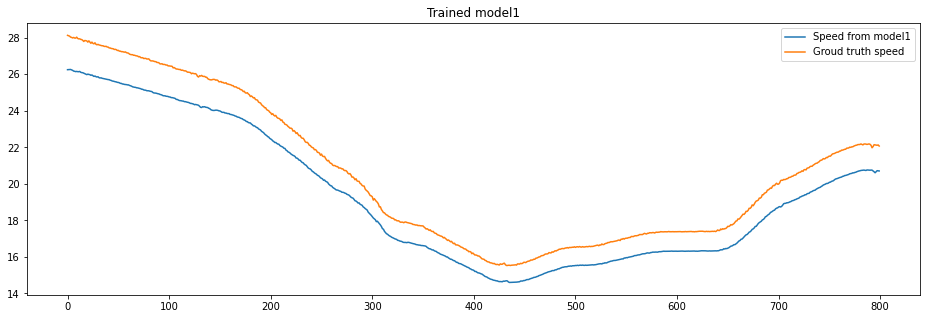

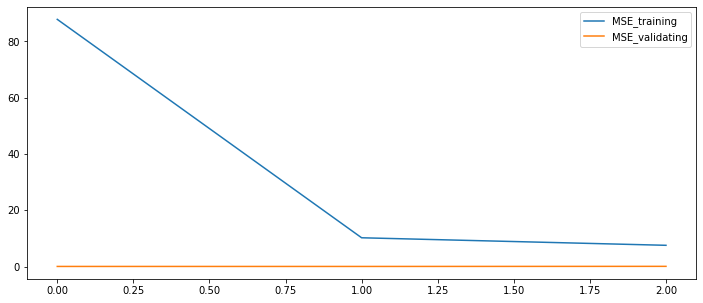

In [13]:
start1, start2 = 0, 0
t_size = 800
data_Train = getTestData1(frame_dir, data[0], data[2], t_size, time_step, start1)
# data_Test = getTestData1(frame_dir, data[1], data[3], t_size, time_step, start2)

print(data_Train[0][0].shape)
model =  tensorflow.keras.models.load_model('N2Ncomma_1.h5')
speed_train = model.predict([data_Train[0][0], data_Train[0][1]])
#speed_test = model.predict([data_Test[0][0], data_Train[0][1]])

plt.figure(figsize=(16,5))
plt.plot(speed_train, label='Speed from model1')
plt.plot(data_Train[1], label='Groud truth speed')
plt.title('Trained model1')
plt.legend()
plt.show()

#plt.figure(figsize=(16,5))
#plt.plot(speed_test, label='Speed from model')
#plt.plot(data_Test[1], label='Groud truth speed')
#plt.title('Testing model')
#plt.legend()
#plt.show()

history_1 = np.load('history_1.npy', allow_pickle = True)[()]
plt.figure(figsize=(12,5))
plt.plot(history_1['loss'], label='MSE_training')
plt.plot(history_1['val_loss'], label='MSE_validating')
plt.legend()
plt.show()

# N2N_model2 Training

In [17]:
model_2 = N2N_model2()
history_2 = train_model(model_2, *data)
model_2.save('N2Ncomma_2.h5')
np.save('history_2.npy', history_2.history)

Model: "functional_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 4, 100, 220, 3)]  0         
_________________________________________________________________
time_distributed (TimeDistri (None, 4, 88000)          57120     
_________________________________________________________________
bidirectional (Bidirectional (None, 2)                 704016    
_________________________________________________________________
dense (Dense)                (None, 30)                90        
_________________________________________________________________
dropout_2 (Dropout)          (None, 30)                0         
_________________________________________________________________
dense_1 (Dense)              (None, 10)                310       
_________________________________________________________________
dense_2 (Dense)              (None, 1)                

(800, 4, 100, 220, 3)


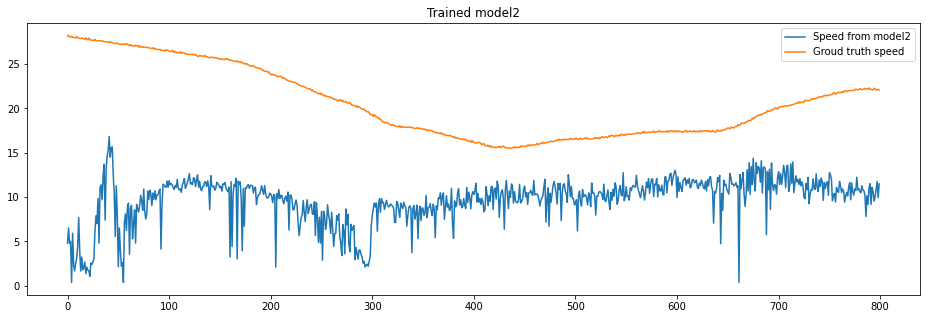

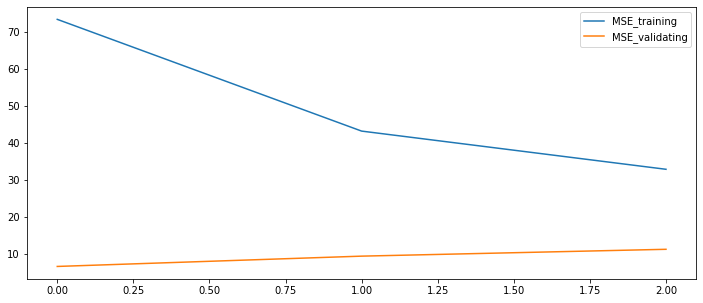

In [23]:
start1, start2 = 0, 0
t_size = 800
data_Train = getTestData(frame_dir, data[0], data[2], t_size, time_step, start1)
# data_Test = getTestData(frame_dir, data[1], data[3], t_size, time_step, start2)

print(data_Train[0].shape)
model =  tensorflow.keras.models.load_model('N2Ncomma_2.h5')
speed_train = model.predict(data_Train[0])
#speed_test = model.predict(data_Test[0])

plt.figure(figsize=(16,5))
plt.plot(speed_train, label='Speed from model2')
plt.plot(data_Train[1], label='Groud truth speed')
plt.title('Trained model2')
plt.legend()
plt.show()

#plt.figure(figsize=(16,5))
#plt.plot(speed_test, label='Speed from model')
#plt.plot(data_Test[1], label='Groud truth speed')
#plt.title('Testing model')
#plt.legend()
#plt.show()

history_2 = np.load('history_2.npy', allow_pickle = True)[()]
plt.figure(figsize=(12,5))
plt.plot(history_2['loss'], label='MSE_training')
plt.plot(history_2['val_loss'], label='MSE_validating')
plt.legend()
plt.show()

# N2N_model3 Training

In [29]:
model_3 = N2N_model3()
history_3 = train_model1(model_3, *data, time_step)
model_3.save('N2Ncomma_3.h5')
np.save('history_3.npy', history_3.history)

Model: "functional_21"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_21 (InputLayer)           [(None, 4, 100, 220, 0                                            
__________________________________________________________________________________________________
time_distributed_10 (TimeDistri (None, 4, 11648)     108352      input_21[0][0]                   
__________________________________________________________________________________________________
input_22 (InputLayer)           [(None, 4)]          0                                            
__________________________________________________________________________________________________
bidirectional_10 (Bidirectional (None, 30)           1399680     time_distributed_10[0][0]        
______________________________________________________________________________________

(800, 4, 100, 220, 3)


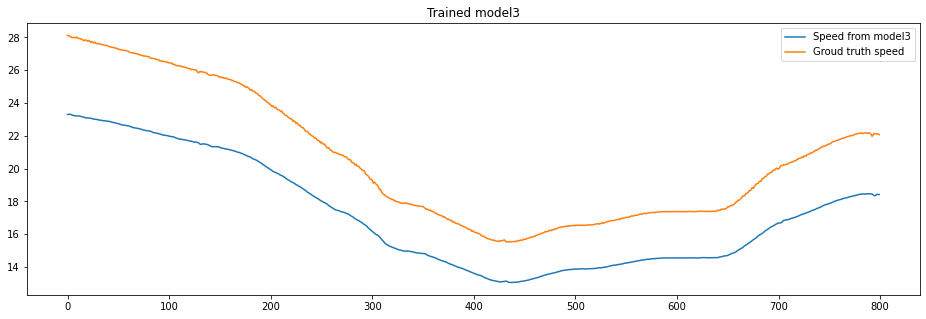

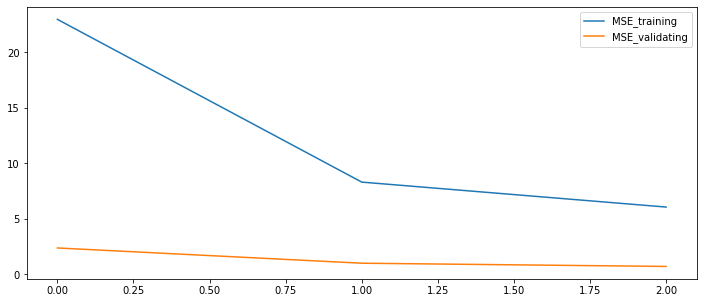

In [24]:
start1, start2 = 0, 0
t_size = 800
data_Train = getTestData1(frame_dir, data[0], data[2], t_size, time_step, start1)
# data_Test = getTestData1(frame_dir, data[1], data[3], t_size, time_step, start2)

print(data_Train[0][0].shape)
model =  tensorflow.keras.models.load_model('N2Ncomma_3.h5')
speed_train = model.predict([data_Train[0][0], data_Train[0][1]])
#speed_test = model.predict([data_Test[0][0], data_Train[0][1]])

plt.figure(figsize=(16,5))
plt.plot(speed_train, label='Speed from model3')
plt.plot(data_Train[1], label='Groud truth speed')
plt.title('Trained model3')
plt.legend()
plt.show()

#plt.figure(figsize=(16,5))
#plt.plot(speed_test, label='Speed from model')
#plt.plot(data_Test[1], label='Groud truth speed')
#plt.title('Testing model')
#plt.legend()
#plt.show()

history_3 = np.load('history_3.npy', allow_pickle = True)[()]
plt.figure(figsize=(12,5))
plt.plot(history_3['loss'], label='MSE_training')
plt.plot(history_3['val_loss'], label='MSE_validating')
plt.legend()
plt.show()

# Model Testing

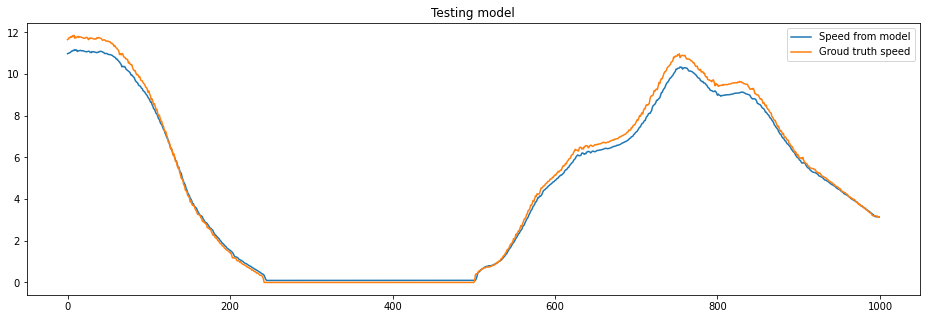

In [14]:
model =  tensorflow.keras.models.load_model('N2Ncomma_1.h5')
start1, start2 = 0, 0
t_size = 1000
data_Test = getTestData1(frame_dir, data[1], data[3], t_size, time_step, start2)
speed_test = model.predict(data_Test[0])

plt.figure(figsize=(16,5))
plt.plot(speed_test, label='Speed from model')
plt.plot(data_Test[1], label='Groud truth speed')
plt.title('Testing model')
plt.legend()
plt.show()

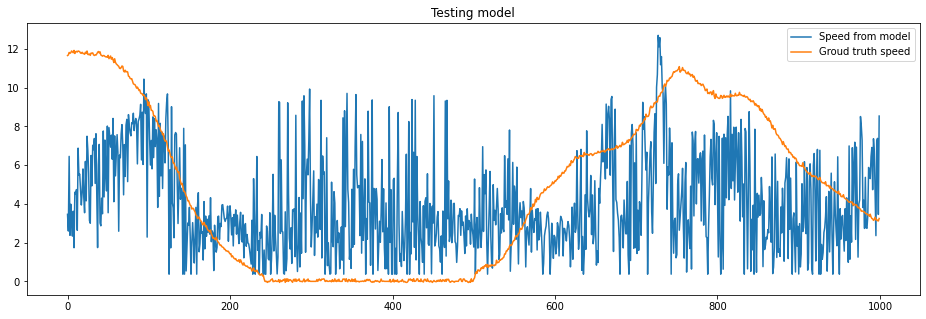

In [14]:
model =  tensorflow.keras.models.load_model('N2Ncomma_2.h5')
start1, start2 = 0, 0
t_size = 1000
data_Test = getTestData(frame_dir, data[1], data[3], t_size, time_step, start2)
speed_test = model.predict(data_Test[0])

plt.figure(figsize=(16,5))
plt.plot(speed_test, label='Speed from model')
plt.plot(data_Test[1], label='Groud truth speed')
plt.title('Testing model')
plt.legend()
plt.show()

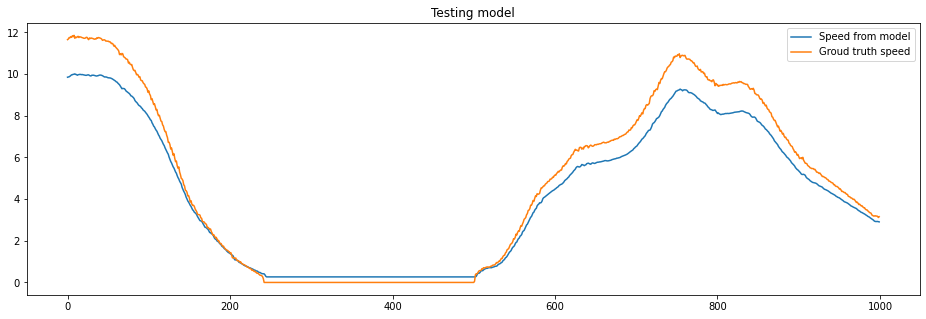

In [14]:
model =  tensorflow.keras.models.load_model('N2Ncomma_3.h5')
start1, start2 = 0, 0
t_size = 1000
data_Test = getTestData1(frame_dir, data[1], data[3], t_size, time_step, start2)
speed_test = model.predict(data_Test[0])

plt.figure(figsize=(16,5))
plt.plot(speed_test, label='Speed from model')
plt.plot(data_Test[1], label='Groud truth speed')
plt.title('Testing model')
plt.legend()
plt.show()